In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import seaborn as sns

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=True, n_workers=7, threads_per_worker=8, memory_limit='25GB')

client

Client Scheduler: tcp://127.0.0.1:34895 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 56 Memory: 175.00 GB


In [3]:
from loren_frank_data_processing import make_epochs_dataframe
from src.parameters import ANIMALS

epoch_info = make_epochs_dataframe(ANIMALS)
epoch_info.xs('remy', drop_level=False)

environment   type  exposure
animal day epoch                             
remy   35  1           sleep  sleep       NaN
           2          wtrack    run       1.0
           3           sleep  sleep       NaN
           4          wtrack    run       2.0
           5           sleep  sleep       NaN
       36  1           sleep  sleep       NaN
           2          wtrack    run       3.0
           3           sleep  sleep       NaN
           4          wtrack    run       4.0
           5           sleep  sleep       NaN
       37  1           sleep  sleep       NaN
           2          wtrack    run       5.0
           3           sleep  sleep       NaN
           4          wtrack    run       6.0
           5           sleep  sleep       NaN

In [4]:
from src.load_data import load_data

epoch_key = ('remy', 35, 2)

data = load_data(epoch_key)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:48274 remote=tcp://127.0.0.1:34895>
INFO:src.load_data:Finding ripple times...
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:48278 remote=tcp://127.0.0.1:34895>


In [5]:
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)
from replay_trajectory_classification import ClusterlessClassifier

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_labels = data['position_info'].arm_name

logging.info('Fitting classifier...')
classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
        position, data['multiunit'], is_training=is_training,
        track_labels=track_labels)
logging.info(classifier)

INFO:root:Fitting classifier...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...
INFO:root:ClusterlessClassifier(continuous_transition_types=[['w_track_1D_random_walk_minus_identity',
                                                    'w_track_1D_inverse_random_walk',
                                                    'identity'],
                                                   ['uniform',
                                                    'w_track_1D_inverse_random_walk',
                                                    'uniform'],
                                                   ['w_track_1D_random_walk_minus_identity',
                                                    'w_track_1D_inverse_random_walk',
                                                    'identity']],
                      discret

In [6]:
from scipy.ndimage import label
from tqdm import tqdm

labels, _ = label(~is_training)
results = []

for label_name, df in tqdm(pd.DataFrame(labels, index=is_training.index, columns=['labels']).groupby('labels')):
    if label_name != 0:
        m = data['multiunit'].sel(time=df.index)
        results.append(classifier.predict(m, time=m.time))

  0%|          | 0/339 [00:00<?, ?it/s]distributed.utils - ERROR - An asyncio.Future, a coroutine or an awaitable is required
Traceback (most recent call last):
  File "/home/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/dashboard/components.py", line 561, in cb
    prof, metadata = await asyncio.gather(prof, metadata)
  File "/home/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/asyncio/tasks.py", line 602, in gather
    fut = ensure_future(arg, loop=loop)
  File "/home/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/asyncio/tasks.py", line 526, in ensure_future
    raise TypeError('An asyncio.Future, a coroutine or an awaitable is '
TypeError: An asyncio.Future, a coroutine or an awaitable is required
tornado.application - ERROR - Exception in callback functools.partial(<bound m

In [13]:
results[-1]

<xarray.Dataset>
Dimensions:            (position: 214, state: 3, time: 214)
Coordinates:
  * time               (time) timedelta64[ns] 00:47:34.632200 ... 00:47:35.058200
  * position           (position) float64 -0.9969 0.9969 2.991 ... 421.7 423.7
  * state              (state) <U37 'w_track_1D_random_walk_minus_identity' ... 'identity'
Data variables:
    likelihood         (time, state, position) float64 1.0 1.518e-42 ... 0.0995
    causal_posterior   (time, state, position) float64 0.0 0.01606 ... 9.244e-09
    acausal_posterior  (time, state, position) float64 0.0 ... 9.244e-09

In [59]:
r = xr.concat(results, dim='time')

In [79]:
from src.parameters import TRANSITION_TO_CATEGORY

ripple_results = []
for ripple_number in tqdm(data['ripple_times'].index):
    df = data['ripple_times'].loc[ripple_number]
    ds = (r.sel(time=slice(df.start_time, df.end_time))
           .assign_coords(time=lambda ds: ds.time - ds.time[0])
           .drop(['likelihood', 'causal_posterior']))
    ripple_results.append(ds)

ripple_results = xr.concat(ripple_results, dim=data['ripple_times'].index)
ripple_results = ripple_results.assign_coords(
            state=lambda ds: ds.state.to_index()
            .map(TRANSITION_TO_CATEGORY))

100%|██████████| 344/344 [00:01<00:00, 323.40it/s]


In [80]:
ripple_results

<xarray.Dataset>
Dimensions:            (position: 214, ripple_number: 344, state: 3, time: 132)
Coordinates:
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.262000
  * position           (position) float64 -0.9969 0.9969 2.991 ... 421.7 423.7
  * state              (state) object 'continuous' 'fragmented' 'hover'
  * ripple_number      (ripple_number) int64 1 2 3 4 5 6 ... 340 341 342 343 344
Data variables:
    acausal_posterior  (ripple_number, time, state, position) float64 0.0 ... nan

In [81]:
ripple_results.sel(ripple_number=1).dropna('time')

<xarray.Dataset>
Dimensions:            (position: 214, state: 3, time: 27)
Coordinates:
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.052000
  * position           (position) float64 -0.9969 0.9969 2.991 ... 421.7 423.7
  * state              (state) object 'continuous' 'fragmented' 'hover'
    ripple_number      int64 1
Data variables:
    acausal_posterior  (time, state, position) float64 0.0 ... 6.073e-09

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7f1aec535dd8>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7f1aec5337b8>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7f1aec4dbf60>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7f1aec501f98>}

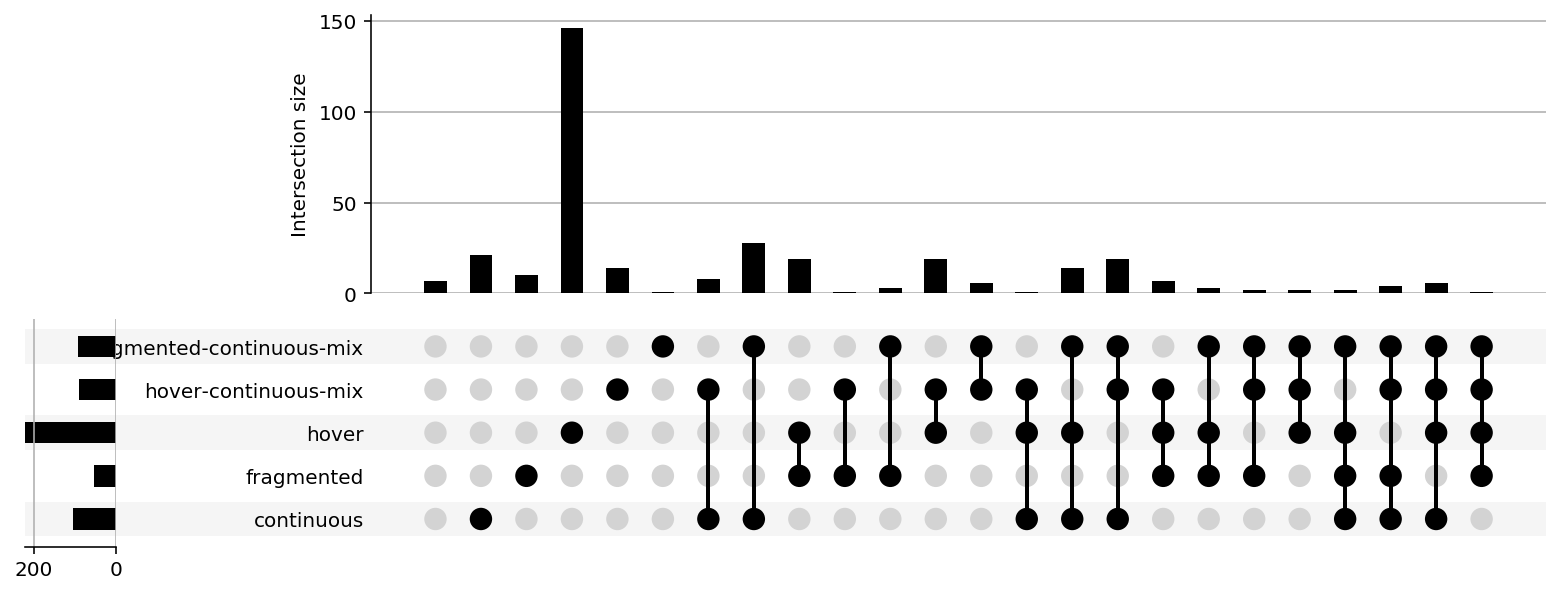

In [88]:
from src.analysis import get_probability, get_is_classified
from src.visualization import plot_category_counts

probability_threshold = 0.8
sampling_frequency = SAMPLING_FREQUENCY


probability = get_probability(ripple_results)
is_classified = get_is_classified(probability, probability_threshold)
duration = (is_classified.sum('time') / sampling_frequency)
duration = duration.to_dataframe().unstack(level=1)
duration.columns = list(duration.columns.get_level_values('state'))
duration = duration.rename(
    columns=lambda column_name: column_name + '_duration')
is_category = (duration > 0.0).rename(columns=lambda c: c.split('_')[0])
duration = pd.concat((duration, is_category), axis=1)
duration['is_classified'] = np.any(duration > 0.0, axis=1)

plot_category_counts(duration)